# Home Credit data
# Notebook 3: Machine Learning Modeling - Default prediction

**Table of contents**<a id='toc0_'></a>    
- 1. [Importing libraries](#toc1_)    
- 2. [Loading data](#toc2_)    
- 3. [Target](#toc3_)    
  - 3.1. [Target label](#toc3_1_)    
  - 3.2. [Handling class imbalance](#toc3_2_)    
  - 3.3. [Separating target](#toc3_3_)    
- 4. [Metric definition](#toc4_)    
- 5. [AutoML](#toc5_)    
  - 5.1. [AutoML as baseline](#toc5_1_)    
  - 5.2. [Model algorithm selection](#toc5_2_)    
  - 5.3. [Important features](#toc5_3_)    
- 6. [Standalone model: Training, Tuning, and Evaluation](#toc6_)    
  - 6.1. [Preprocessing](#toc6_1_)    
  - 6.2. [CatBoost model with default parameter](#toc6_2_)    
    - 6.2.1. [Feature Importance and Feature Selection Analysis](#toc6_2_1_)    
  - 6.3. [CatBoost models based on feature subsets](#toc6_3_)    
    - 6.3.1. [Subset with most important features](#toc6_3_1_)    
    - 6.3.2. [Subset excluding EXT_SOURCE](#toc6_3_2_)    
  - 6.4. [Hyperparameter Tuning](#toc6_4_)    
    - 6.4.1. [CatBoost model with optimized number of features](#toc6_4_1_)    
    - 6.4.2. [CatBoost model excluding EXT_SOURCE](#toc6_4_2_)    
  - 6.5. [Threshold optimization and final model performances](#toc6_5_)    
    - 6.5.1. [CatBoost model n=18](#toc6_5_1_)    
    - 6.5.2. [CatBoost model n=36](#toc6_5_2_)    
  - 6.6. [Saving final pipelines and SHAP explainer ](#toc6_6_)    
- 7. [Test prediction and Submission](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Importing libraries](#toc0_)

In [1]:
import os
import sys

import eli5
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import shap
from catboost import (
    CatBoostClassifier,
    Pool,
    cv,
    EShapCalcType,
    EFeaturesSelectionAlgorithm,
)
from pydantic import create_model
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline
from supervised.automl import AutoML

sys.path.append(os.path.abspath(".."))
from src.utils import (
    plot_feature_distribution,
    create_feature_subset_excluding_list,
    plot_feature_selection_elbow_improved,
    get_confusion_matrix_df,
    run_cv_on_subset,
    create_feature_subset,
)

## 2. <a id='toc2_'></a>[Loading data](#toc0_)

In Notebook 1 we have merged the aggregated features from the subtables into the main data file, and processed, cleaned and transformed the main features. We will model on that file:

In [10]:
app_train_merged = pd.read_parquet("../data/processed/app_train_merged.parquet")

In [11]:
app_test_merged = pd.read_parquet("../data/processed/app_test_merged.parquet")

In [12]:
train_cols = set(app_train_merged.columns)
test_cols = set(app_test_merged.columns)

only_in_train = train_cols - test_cols
only_in_test = test_cols - train_cols

print("Columns only in train data:")
print(sorted(only_in_train))

print("\nColumns only in test data:")
print(sorted(only_in_test))

Columns only in train data:
['TARGET']

Columns only in test data:
[]


## 3. <a id='toc3_'></a>[Target](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Target label](#toc0_)

The prediction label used here is default risk, represented in the dataset already as `TARGET`.


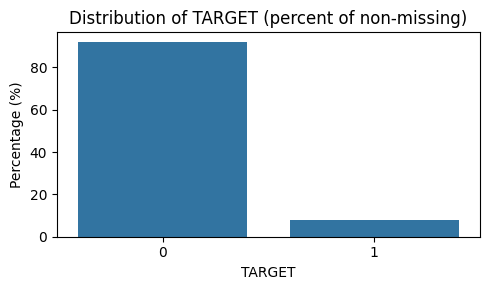

In [13]:
plot_feature_distribution(app_train_merged, "TARGET")

### 3.2. <a id='toc3_2_'></a>[Handling class imbalance](#toc0_)

The highly imbalanced nature of the dataset makes it difficult to train a model effectively, resulting in a skewed loss function, domination of the majority class, and difficulty in class separation. While testing for techniques to handle the imbalanced data, instead of **data-based solutions** (*under*- and *oversampling* via SMOTE) we finally use a ***algorithm-based solutions***: cost-sensitive learning (e.g. scale_pos_weight for the XGboost model). Moreover we apply ***threshold tuning*** to improve model’s performance on the minority class.

### 3.3. <a id='toc3_3_'></a>[Separating target](#toc0_)

We do not use a fixed set of the training data as validation data, but to assess our model performances before submitting the results of the test data prediction, we perform cross-validations. Previous projects proved that it is more robust against overfitting.

We only split the features from the target but also drop unuseful identifier from training data:

In [14]:
X_train = app_train_merged.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = app_train_merged["TARGET"]

In [15]:
X_test = app_test_merged.drop(columns=["SK_ID_CURR"])

## 4. <a id='toc4_'></a>[Metric definition](#toc0_)

The chosen performance metric for evaluating the ***best model*** and ***its settings*** (hyperparameter tuning) is the **ROC AUC** (Receiver Operating Characteristic – Area Under the Curve). Unlike accuracy-based metrics, ROC AUC measures the model’s ability to distinguish between classes across all classification thresholds, making it particularly suitable for imbalanced datasets by evaluating the true positive rate against the false positive rate.

We also chose the ROC AUC metric because it aligns with our core objective. Our goal is to develop a model that effectively flags clients with a high risk of default (true positives) while simultaneously avoiding mislabeling low-risk clients as high-risk (false positives). A high ROC AUC score indicates a strong ability to make this distinction.

In addition, other key metrics such as accuracy, precision, and recall will be reported alongside confusion matrices, and ROC curves will be analyzed to provide a comprehensive assessment of model performance. 

Moreover, we will optimize the ***classification threshold*** (decision point) by prioritizing **Recall**. The general reasoning for a default risk model is to favor recall over precision since the direct financial loss from a default (a false negative) is usually high. This is the most common approach for most financial institutions. While false positives are an inconvenience and a lost opportunity, false negatives are a direct and often significant financial loss. The model's main purpose is to prevent these losses, making recall the more critical metric. In practice, a credit risk model's threshold is tuned to strike a balance where the combined cost of false positives and false negatives is minimized, but with a strong bias towards capturing as many true defaulters as possible.

## 5. <a id='toc5_'></a>[AutoML](#toc0_)

### 5.1. <a id='toc5_1_'></a>[AutoML as baseline](#toc0_)

In a first step we use **[MLJAR Automated Machine Learning for Humans](https://github.com/mljar/mljar-supervised)**, which automatizes the whole modelling process, to derive a model as a **baseline**. 

To cope with the target imbalance we need to add sample weights:

In [163]:
pos_weight = len(y_train) / (2 * sum(y_train))
neg_weight = len(y_train) / (2 * sum(1 - y_train))

sample_weight = np.where(y_train == 1, pos_weight, neg_weight)

In [165]:
automl_1 = AutoML(
    results_path="AutoML_1",
    mode="Compete",
    eval_metric="auc",
    explain_level=2,
    random_state=42,
)
automl_1.fit(X_train, y_train, sample_weight=sample_weight)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree auc 0.706358 trained in 308.18 seconds
Disable stacking for split validation
* Step simple_algorithms will try to check up to 2 models
2_DecisionTree auc 0.666149 trained in 166.3 seconds
3_DecisionTree auc 0.666149 trained in 151.1 seconds
* Step default_algorithms will try to check up to 6 models
4_Default_LightGBM

,results_path,'AutoML_1'
,total_time_limit,3600
,mode,'Compete'
,ml_task,'auto'
,model_time_limit,None
,algorithms,'auto'
,train_ensemble,True
,stack_models,'auto'
,eval_metric,'auc'
,validation_strategy,'auto'
,explain_level,2


The best model is the **Ensemble** as here in the [ReadMe]( AutoML_1/README.md) shown.


In [ ]:
automl_9 = AutoML(
    results_path="AutoML_9",
    mode="Compete",
    eval_metric="auc",
    explain_level=2,
    random_state=42,
)
automl_9.fit(X_train, y_train, sample_weight=sample_weight)

Linear algorithm was disabled.
AutoML directory: AutoML_9
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree auc 0.706358 trained in 247.18 seconds
Disable stacking for split validation
* Step simple_algorithms will try to check up to 2 models
2_DecisionTree auc 0.666149 trained in 225.17 seconds
3_DecisionTree auc 0.666149 trained in 174.68 seconds
* Step default_algorithms will try to check up to 6 models
4_Default_LightG

,results_path,'AutoML_9'
,total_time_limit,3600
,mode,'Compete'
,ml_task,'auto'
,model_time_limit,None
,algorithms,'auto'
,train_ensemble,True
,stack_models,'auto'
,eval_metric,'auc'
,validation_strategy,'auto'
,explain_level,2


The best model is again the **Ensemble** as here in the [ReadMe]( AutoML_8/README.md) shown.


### 5.2. <a id='toc5_2_'></a>[Model algorithm selection](#toc0_)

With MLJAR in the [ReadMe]( AutoML_8/README.md) we can also inspect most promising model algorithms based on their ROC scores.

Across all AutoML sessions, **CatBoost** and **LightGBM** were the most promising standalone models, and consequently had also the highest weight among all models in the ensemble. The ensemble consisted of Gradient Boosting models only.

We will use **CatBoost** as a starting point for the manual modeling in the next chapter.

### 5.3. <a id='toc5_3_'></a>[Important features](#toc0_)

With MLJAR in the [ReadMe]( AutoML_8/README.md) we can also inspect the most promising features.

Interesting is that less complex models (Decision Tree, Random Forest) rely heavily on `EXT_SOURCE_3` and `EXT_SOURCE_2`, while more complex models (LightGBM, XGBoost, Catboost, Ensemble) build more on `DAYS_BIRTH`, `CODE_GENDER` and `EXT_SOURCE_1`. We will further inspect this in the **Feature importance** section in the standalone model.

## 6. <a id='toc6_'></a>[Standalone model: Training, Tuning, and Evaluation](#toc0_)

### 6.1. <a id='toc6_1_'></a>[Preprocessing](#toc0_)

Though, the CatBoost algorithm is actually designed to handle missing values automatically (unique method by treating it as a distinct category), it turns out that **imputation** of missing values is essential for our modelling process somewhat. However, other **encoding** is not required.

Therefore we define a preprocessor and transform the training and test data with simple imputers:

In [ ]:
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="constant", fill_value=0), numerical_features),  # None, np.nan
        (
            "cat",
            SimpleImputer(strategy="constant", fill_value="missing"),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

all_features = numerical_features.tolist() + categorical_features.tolist()
X_train_processed_df = pd.DataFrame(
    X_train_processed, columns=all_features, index=X_train.index
)
X_test_processed_df = pd.DataFrame(
    X_test_processed, columns=all_features, index=X_test.index
)

for col in categorical_features:
    X_train_processed_df[col] = X_train_processed_df[col].astype(str)
    X_test_processed_df[col] = X_test_processed_df[col].astype(str)

for col in numerical_features:
    X_train_processed_df[col] = pd.to_numeric(
        X_train_processed_df[col], errors="coerce"
    )
    X_test_processed_df[col] = pd.to_numeric(X_test_processed_df[col], errors="coerce")

train_pool = Pool(
    data=X_train_processed_df, label=y_train, cat_features=categorical_features.tolist()
)
test_pool = Pool(data=X_test_processed_df, cat_features=categorical_features.tolist())

### 6.2. <a id='toc6_2_'></a>[CatBoost model with default parameter](#toc0_)

The CatBoost model was one of the best performing during the AutoML modeling exploration phase. We want to measure the performance of a single CatBoost classifier. In an iterative process we take into account the hypertuning of model parameters and want to discover most important features for selection.

We account for imbalanced data and improve prediciton of the minority class by setting `'auto_class_weights': 'Balanced'`.

We use CatBoosts internal **crossvalidation** to test for initial prediction scores.

Number of `iterations` is by default 1000. The `learning_rate` usually depends on the `loss_function`, but we set it higher for faster cross-validation. We introduce `early_stopping_rounds` to abort useless continuation of iterations. 

In [17]:
catboost_params = {
    "iterations": 1000,
    "learning_rate": 0.3,
    "early_stopping_rounds": 50,
    "eval_metric": "AUC",
    "verbose": 0,
    "auto_class_weights": "Balanced",
    "random_state": 42,
    "loss_function": "Logloss",
}

cv_results = cv(train_pool, params=catboost_params, fold_count=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.7729280012
bestIteration = 103

Training on fold [1/3]

bestTest = 0.7788651619
bestIteration = 72

Training on fold [2/3]

bestTest = 0.7786215722
bestIteration = 69



In [18]:
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(
    X_train_processed_df, y_train, cat_features=categorical_features.tolist()
)

#### 6.2.1. <a id='toc6_2_1_'></a>[Feature Importance and Feature Selection Analysis](#toc0_)

The **Feature Selection Analysis** for this project was a key step in building an efficient and interpretable model. I implemented a multi-stage feature selection process to identify a minimal set of features that maintained high predictive power:

1) **Initial Importance Analysis**: I used a CatBoost model with default parameters to analyze feature importance using a combination of methods, including Feature Analysis Chart, PredictionValuesChange, LossFunctionChange, eli5, and SHAP values.

2) **Elbow Method**: I applied the Elbow Method to the cumulative feature importance curve to identify the point where the returns began to diminish. This heuristic helped me determine an optimal number of features for the final models.

3) **Recursive Feature Elimination**: To further refine the feature set, I used CatBoost's built-in feature selection, which employs a Recursive Feature Elimination algorithm. By combining this with the RecursiveByLossFunctionChange method, I was able to efficiently reduce the number of columns without a significant loss of information.

**Feature Selection Analysis - Step 1: Initial Importance Analysis** 


**[Feature analysis chart:](https://catboost.ai/docs/en/concepts/feature-analysis-graph)**

This functionality provides calculated and plotted feature-specific statistics and visualizes how CatBoost is splitting the data for each feature. More specifically, the statistics are:

- Mean target value for each bin (bins groups continuous feature) or category (supported currently for only One-Hot Encoded features)
- Mean prediction value for each bin
- Number of data instances (object) in each bin
- Predictions for various feature values


In [19]:
res = catboost_model.calc_feature_statistics(
    X_train_processed_df,
    y_train,
    feature=["EXT_SOURCE_3", "AGE", "AMT_CREDIT"],
    plot=True,
)

**PredictionValuesChange**: This shows how much, on average, the prediction changes over the feature value changes. The bigger the average values of prediction changes due to features, the higher the importance.

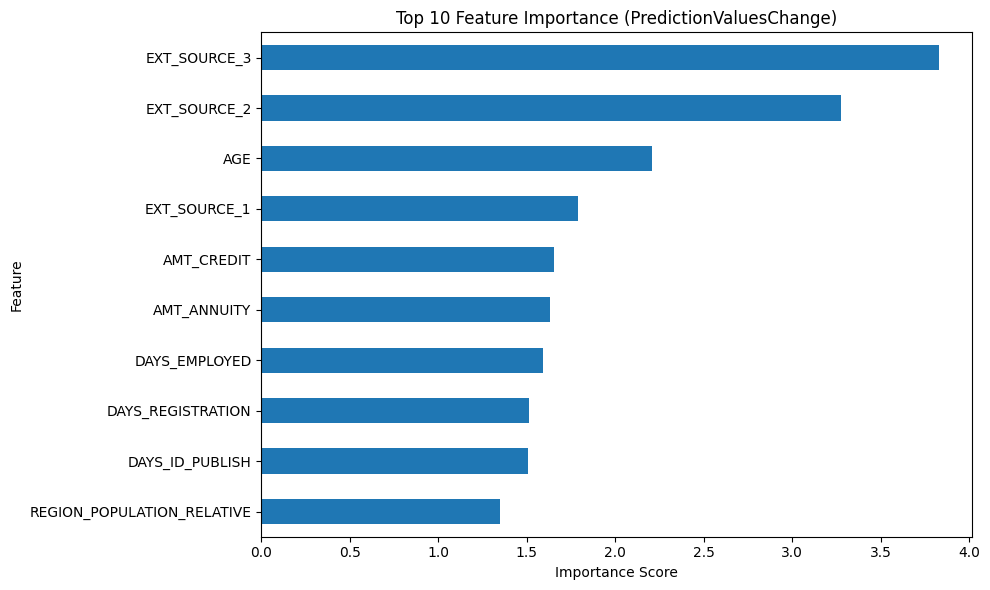

In [20]:
prediction_value_change_importance = catboost_model.get_feature_importance(
    data=train_pool, type="PredictionValuesChange"
)

pv_change_series = pd.Series(prediction_value_change_importance, index=all_features)
sorted_pv_change = pv_change_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_pv_change.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance (PredictionValuesChange)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**LossFunctionChange**: This is a heavy computing technique that gets feature importance by taking the difference between the loss function of a model, including a given feature, and the model without that feature. The higher the difference, the more the feature is important.


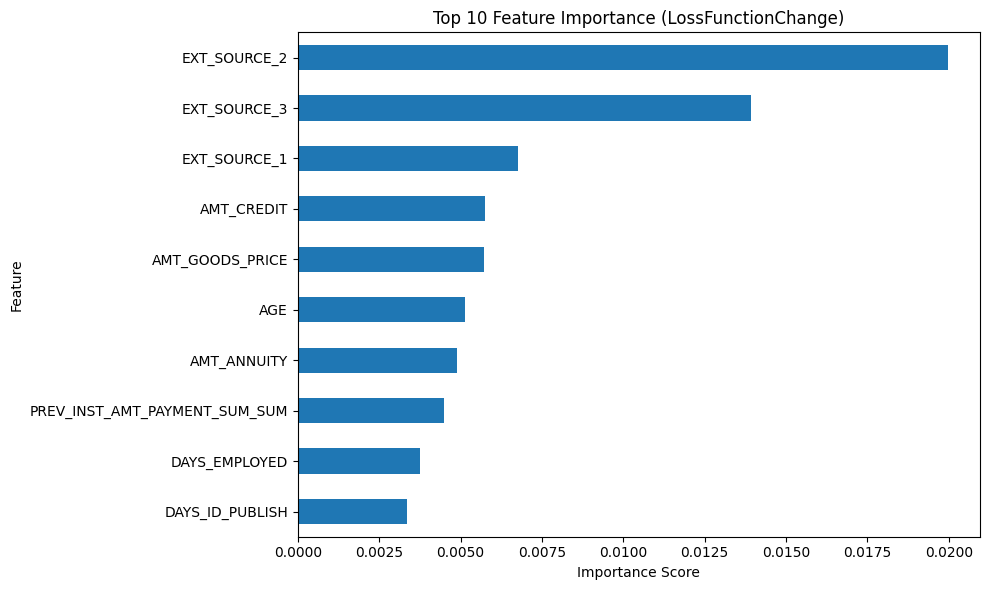

In [21]:
loss_function_change_importance = catboost_model.get_feature_importance(
    data=train_pool, type="LossFunctionChange"
)

loss_change_series = pd.Series(loss_function_change_importance, index=all_features)
sorted_loss_change = loss_change_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_loss_change.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance (LossFunctionChange)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
feature_names = X_train_processed_df.columns.tolist()
eli5.show_weights(catboost_model, feature_names=feature_names)

Weight,Feature
0.0348,EXT_SOURCE_3
0.0296,EXT_SOURCE_2
0.0217,AGE
0.0184,EXT_SOURCE_1
0.0176,AMT_CREDIT
0.0169,AMT_ANNUITY
0.0166,DAYS_EMPLOYED
0.0155,DAYS_REGISTRATION
0.0151,DAYS_ID_PUBLISH
0.0140,AMT_GOODS_PRICE


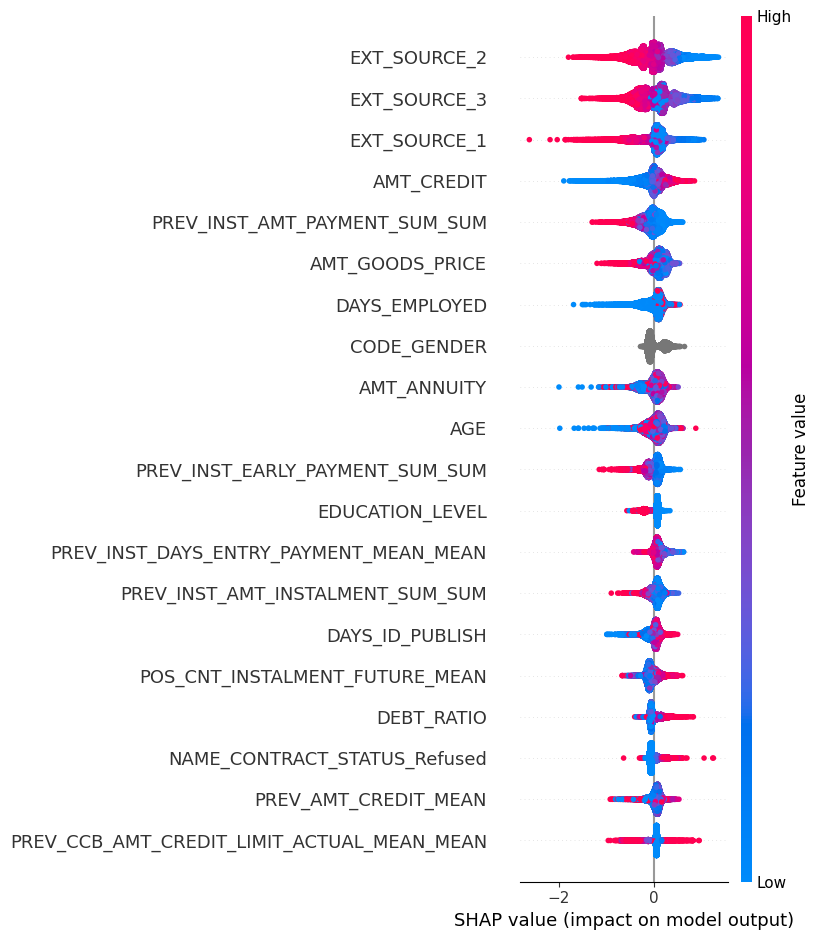

In [23]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test_processed_df)
shap.summary_plot(shap_values, X_test_processed_df)

**Important categorical features and the shap values of their categories:**

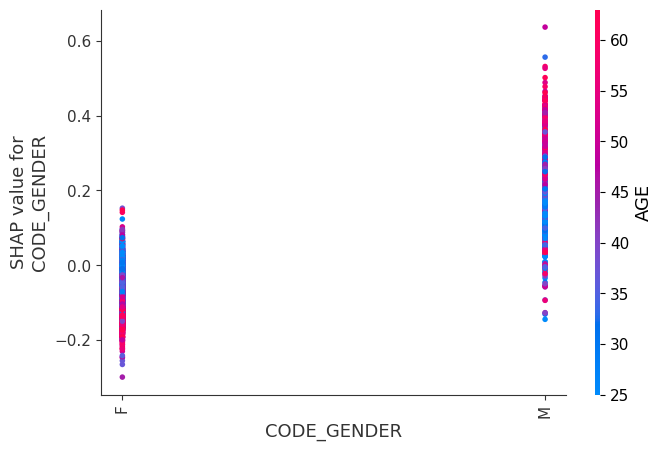

In [24]:
shap.dependence_plot(
    "CODE_GENDER", shap_values, X_test_processed_df, interaction_index="AGE"
)

The combination of `AGE` and `CODE_GENDER` is interesting, since the direction of the shap values for the age flips by gender: Older females tend to not default, while older men tend to default.

**Summary**

It's reassuring that different interpretability methods (eli5, LossFunctionChange, PredictionValuesChange, ShapValues) are converging on the same set of important features, which boosts confidence in the findings.

Moreover, the findings correspond to the ones from the AutoML models, however, they allign more with the simpler models' important features. 

The three `EXT_SOURCE` scores are particularly important for the prediction, which the EDA already revealed and the AutoML feature importance analysis showed. 

Other important features are: `AMT_CREDIT`,  `AMT_ANNUITY`, `AMT_GOODS_PRICE`, which are all directly related to the loan and loaned object. 

A socio-demographic features of very high importance is `AGE`, but also `CODE_GENDER`, `DAYS_EMPLOYED`. 

Among the engineered features most important is the `DEBT_TO_INCOME_RATIO` and among the aggregated features from the subtables most interesting are `PREV_INST_AMT_PAYMENT_SUM_SUM` and `POS_CNT_INSTALMENT_FUTURE_MEAN`. The first sums all actual payments made by the person across all the loans. The latter is the average number of remaining installments across a persons other loans. 

### 6.3. <a id='toc6_3_'></a>[CatBoost models based on feature subsets](#toc0_)

#### 6.3.1. <a id='toc6_3_1_'></a>[Subset with most important features](#toc0_)

**Feature Selection Analysis - Step 2: Elbow Method** 

An optimized way of finding the minimum number of features is to find the point on the ***Cumulative Feature Importance curve*** where the diminishing returns set in. That's a well-known heuristic often called the **Elbow Method**:

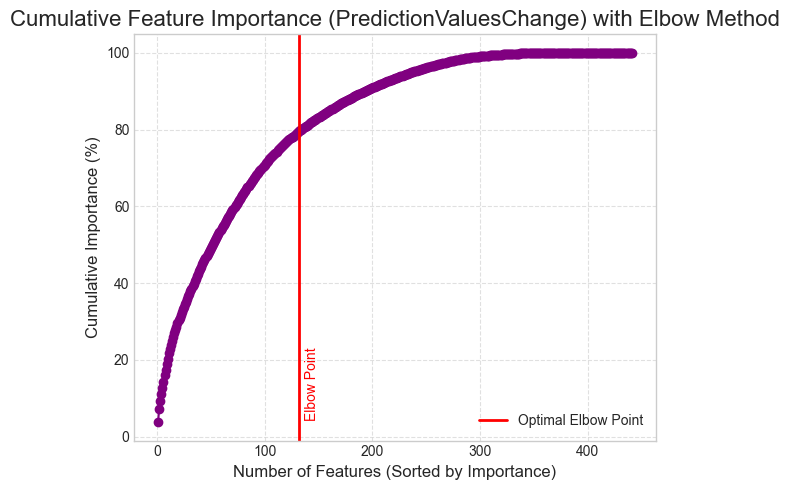

Optimal number of features found with Elbow Method: 132
Cumulative importance at this point: 79.58%


In [25]:
cumulative_importance = sorted_pv_change.cumsum()
cumulative_importance_normalized = (
    cumulative_importance / cumulative_importance.iloc[-1]
) * 100

curve_points = pd.DataFrame(
    {
        "x": range(1, len(cumulative_importance_normalized) + 1),
        "y": cumulative_importance_normalized.values,
    }
)

start_point = curve_points.iloc[0]
end_point = curve_points.iloc[-1]

m = (end_point["y"] - start_point["y"]) / (end_point["x"] - start_point["x"])
c = start_point["y"] - m * start_point["x"]

distances = np.abs(m * curve_points["x"] - curve_points["y"] + c) / np.sqrt(m**2 + 1)

elbow_index = np.argmax(distances)
optimal_num_features = curve_points.iloc[elbow_index]["x"].astype(int)
optimal_importance = curve_points.iloc[elbow_index]["y"]

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6, 5))

plt.plot(
    curve_points["x"],
    cumulative_importance_normalized,
    marker="o",
    linestyle="-",
    color="purple",
)

plt.axvline(
    x=optimal_num_features,
    color="red",
    linestyle="-",
    linewidth=2,
    label="Optimal Elbow Point",
)
plt.text(
    optimal_num_features + 5, 5, "Elbow Point", color="red", fontsize=10, rotation=90
)


plt.title(
    "Cumulative Feature Importance (PredictionValuesChange) with Elbow Method",
    fontsize=16,
)
plt.xlabel("Number of Features (Sorted by Importance)", fontsize=12)
plt.ylabel("Cumulative Importance (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(
    f"Optimal number of features found with Elbow Method: {int(optimal_num_features)}"
)
print(f"Cumulative importance at this point: {optimal_importance:.2f}%")

In [ ]:
X_train_subset_optimized = create_feature_subset(
    catboost_model, X_train_processed_df, optimal_num_features
)
X_test_subset_optimized = create_feature_subset(
    catboost_model, X_test_processed_df, optimal_num_features
)
run_cv_on_subset(
    X_train_subset_optimized, y_train, optimal_num_features, categorical_features
)

Created a subset with 132 features.
Created a subset with 132 features.

--- Running Cross-Validation for Subset: 132 ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7799946068
bestIteration = 344

Training on fold [1/5]

bestTest = 0.7765119763
bestIteration = 363

Training on fold [2/5]

bestTest = 0.7805782832
bestIteration = 356

Training on fold [3/5]

bestTest = 0.7829508876
bestIteration = 272

Training on fold [4/5]

bestTest = 0.7855552229
bestIteration = 303


Results for 132:
Mean AUC: 0.7809
Std AUC: 0.0034


In [29]:
catboost_params = {
    "iterations": 1_000,
    "learning_rate": 0.1,
    "early_stopping_rounds": 50,
    "eval_metric": "AUC",
    "verbose": 0,
    "auto_class_weights": "Balanced",
    "random_state": 42,
    "loss_function": "Logloss",
}

catboost_model_optimized_features = CatBoostClassifier(**catboost_params)
cat_features_subset_optimized = [
    col for col in X_train_subset_optimized.columns if col in categorical_features
]
catboost_model_optimized_features.fit(
    X_train_subset_optimized, y_train, cat_features=cat_features_subset_optimized
)

In [30]:
test_pool_optimized_features = Pool(
    data=X_test_subset_optimized, cat_features=cat_features_subset_optimized
)

Multiple versions of the Organization and Occupation columns are still present:

In [31]:
cat_features_subset_optimized

['CODE_GENDER',
 'NAME_FAMILY_STATUS',
 'ORGANIZATION_TYPE',
 'NAME_INCOME_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_CLUSTER',
 'OCCUPATION_CLUSTER',
 'ORG_PREFIX_GROUP']

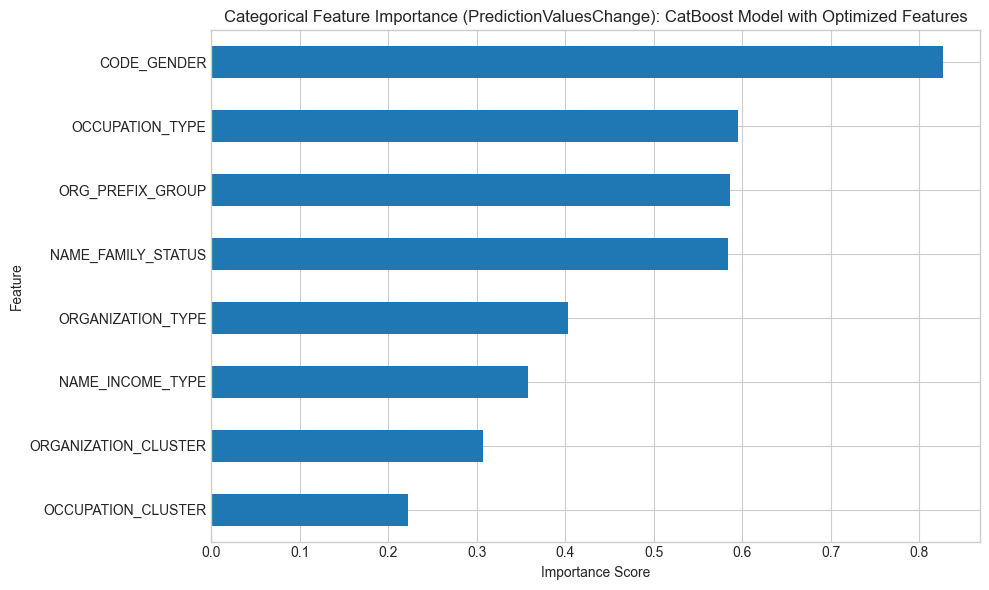

In [32]:
train_pool_optimized_features = Pool(
    data=X_train_subset_optimized,
    label=y_train,
    cat_features=cat_features_subset_optimized,
)

prediction_value_change_importance = (
    catboost_model_optimized_features.get_feature_importance(
        data=train_pool_optimized_features, type="PredictionValuesChange"
    )
)

pv_change_series = pd.Series(
    prediction_value_change_importance,
    index=catboost_model_optimized_features.feature_names_,
)

categorical_importance = pv_change_series.loc[cat_features_subset_optimized]
sorted_categorical_importance = categorical_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_categorical_importance.plot(kind="barh")
plt.title(
    "Categorical Feature Importance (PredictionValuesChange): CatBoost Model with Optimized Features"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Among the categorical features, still `CODE_GENDER` is the most important one.

**Feature Selection Analysis - Step 3: Automatic Feature Selection: Recursive Feature Elimination** 

We use CatBoost's internal Feature Selection method to reduce further the number of columns without loosing too much of information. The main algorithm is **Recursive Feature Elimination** with variable feature importance calculation method `RecursiveByLossFunctionChange`.

The first starting point is to target on a model based on only 20 features:

In [33]:
feature_selection_summary = catboost_model_optimized_features.select_features(
    train_pool_optimized_features,
    features_for_select=list(range(X_train_subset_optimized.shape[1])),
    num_features_to_select=20,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Silent",
    plot=False,
)

During the process of finding the best features and drop harmful features from the dataset we can see from the chart below that actually the optimal moment (Elbow point) was at keeping 18 instead of 20 features:

In [ ]:
elbow_num_features_remaining, elbow_loss_value = plot_feature_selection_elbow_improved(
    feature_selection_summary
)

The number of remaining features at the elbow point is: 18
The corresponding loss value is: 0.4609


We use this information and finally select the best 18 features for our model:

In [35]:
feature_selection_summary = catboost_model_optimized_features.select_features(
    train_pool_optimized_features,
    features_for_select=list(range(X_train_subset_optimized.shape[1])),
    num_features_to_select=elbow_num_features_remaining,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Silent",
    plot=False,
)

In [36]:
feature_selection_summary["selected_features_names"]

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'AGE',
 'EXT_SOURCE_1',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'PREV_INST_AMT_PAYMENT_SUM_SUM',
 'POS_CNT_INSTALMENT_FUTURE_MEAN',
 'DEBT_TO_INCOME_RATIO',
 'ALL_DAYS_CREDIT_max',
 'PREV_INST_DPD_MEAN_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_sum',
 'PREV_DAYS_DECISION_MIN']

We train the model on this subset of top 18 features and submit it to test how well it generalizes:

In [ ]:
X_train_n18 = X_train_subset_optimized[
    feature_selection_summary["selected_features_names"]
]
X_test_n18 = X_test_subset_optimized[
    feature_selection_summary["selected_features_names"]
]

In [ ]:
catboost_params = {
    "iterations": 1_000,
    "learning_rate": 0.1,
    "early_stopping_rounds": 50,
    "eval_metric": "AUC",
    "verbose": 0,
    "auto_class_weights": "Balanced",
    "random_state": 42,
    "loss_function": "Logloss",
}

catboost_model_n18 = CatBoostClassifier(**catboost_params)
cat_features_n18 = [col for col in X_train_n18.columns if col in categorical_features]
catboost_model_n18.fit(X_train_n18, y_train, cat_features=cat_features_n18)

In [59]:
test_pool_n18 = Pool(data=X_test_n18, cat_features=cat_features_n18)

#### 6.3.2. <a id='toc6_3_2_'></a>[Subset excluding EXT_SOURCE](#toc0_)

Overall, the most important features identified are the external credit scores `EXT_SOURCE_x` features. They are typically the strongest indicators of a person's creditworthiness. By deliberately exluding them from the model we want:

- **To check for robustness**: A model that performs well without its top features is often more robust. It's forced to find subtle patterns in the remaining data, which can make it less brittle if the EXT_SOURCE values are ever unavailable or unreliable.

- **To discover hidden insights**: By removing the "easy wins," we can force our model to surface other valuable features that might otherwise be masked by the dominant EXT_SOURCE scores. The features that become important in this new model could reveal interesting, non-obvious relationships in the data.

- **To prepare for real-world scenarios**: Sometimes, in a live application, we might not have access to these exact external scores. Creating a version of our model that doesn't rely on them is a good way to build a backup or an alternative solution that can still perform well.

In [ ]:
columns_to_exclude = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

X_train_without_ext_sources = create_feature_subset_excluding_list(
    X_train_processed_df, columns_to_exclude
)
X_test_without_ext_sources = create_feature_subset_excluding_list(
    X_test_processed_df, columns_to_exclude
)

Created a subset with 438 features, excluding: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
Created a subset with 438 features, excluding: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


In [ ]:
run_cv_on_subset(
    X_train_without_ext_sources,
    y_train,
    "Model without EXT_SOURCE Features",
    categorical_features,
)


--- Running Cross-Validation for Subset: Model without EXT_SOURCE Features ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7576116745
bestIteration = 351

Training on fold [1/5]

bestTest = 0.7566452512
bestIteration = 322

Training on fold [2/5]

bestTest = 0.7610608097
bestIteration = 366

Training on fold [3/5]

bestTest = 0.7598599279
bestIteration = 374

Training on fold [4/5]

bestTest = 0.7615370893
bestIteration = 290


Results for Model without EXT_SOURCE Features:
Mean AUC: 0.7590
Std AUC: 0.0020


In [42]:
catboost_params = {
    "iterations": 1_000,
    "learning_rate": 0.1,
    "early_stopping_rounds": 50,
    "eval_metric": "AUC",
    "verbose": 0,
    "auto_class_weights": "Balanced",
    "random_state": 42,
    "loss_function": "Logloss",
}

catboost_model_excl_EXT_SOURCE = CatBoostClassifier(**catboost_params)

catboost_model_excl_EXT_SOURCE.fit(
    X_train_without_ext_sources, y_train, cat_features=categorical_features.tolist()
)

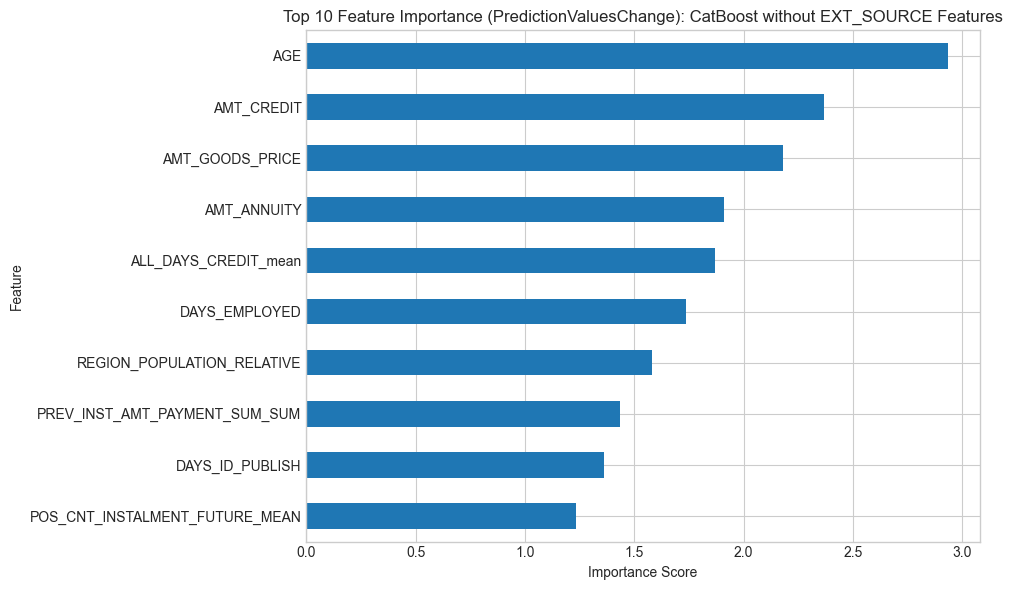

In [43]:
cat_features_without_ext_sources = [
    col for col in X_train_without_ext_sources.columns if col in categorical_features
]

train_pool_without_ext_sources = Pool(
    data=X_train_without_ext_sources,
    label=y_train,
    cat_features=cat_features_without_ext_sources,
)

prediction_value_change_importance = (
    catboost_model_excl_EXT_SOURCE.get_feature_importance(
        data=train_pool_without_ext_sources, type="PredictionValuesChange"
    )
)

pv_change_series = pd.Series(
    prediction_value_change_importance,
    index=catboost_model_excl_EXT_SOURCE.feature_names_,
)
sorted_pv_change = pv_change_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_pv_change.head(10).plot(kind="barh")
plt.title(
    "Top 10 Feature Importance (PredictionValuesChange): CatBoost without EXT_SOURCE Features"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Without the external scores, `AGE` becomes the predominant feature in the prediction model, followed by features related to the loan and loaned product price.

In [44]:
test_pool_without_ext_sources = Pool(
    data=X_test_without_ext_sources, cat_features=cat_features_without_ext_sources
)

**Step 2: Automatic Feature Selection** 

We use again CatBoost's internal Feature Selection method to reduce further the number of columns of this subset excluding the `EXT_SOURCE` features. 

In [45]:
feature_selection_summary = catboost_model_excl_EXT_SOURCE.select_features(
    train_pool_without_ext_sources,
    features_for_select=list(range(X_train_without_ext_sources.shape[1])),
    num_features_to_select=20,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Silent",
    plot=False,
)

During the process of finding the best features and drop harmful features from the dataset we can see from the chart below that actually the optimal moment (Elbow point) was at keeping 36 instead of 20 features:

In [46]:
features_at_elbow, loss_at_elbow = plot_feature_selection_elbow_improved(
    feature_selection_summary
)

The number of remaining features at the elbow point is: 36
The corresponding loss value is: 0.4804


We use this information and finally select the best 36 features for our model:

In [47]:
feature_selection_summary = catboost_model_excl_EXT_SOURCE.select_features(
    train_pool_without_ext_sources,
    features_for_select=list(range(X_train_without_ext_sources.shape[1])),
    num_features_to_select=features_at_elbow,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Silent",
    plot=False,
)

In [48]:
feature_selection_summary["selected_features_names"]

['AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT_W_CITY',
 'AGE',
 'DEBT_TO_INCOME_RATIO',
 'EDUCATION_LEVEL',
 'ALL_DAYS_CREDIT_max',
 'ALL_DAYS_CREDIT_mean',
 'ACTIVE_DAYS_CREDIT_ENDDATE_min',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_mean',
 'ACTIVE_AMT_CREDIT_SUM_max',
 'CREDIT_ACTIVE_COUNT_ACTIVE',
 'DEBT_RATIO',
 'PREV_AMT_ANNUITY_MEAN',
 'PREV_AMT_CREDIT_SUM',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN_MEAN',
 'PREV_CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN_MEAN',
 'PREV_INST_NUM_INSTALMENT_NUMBER_MAX_MAX',
 'PREV_INST_AMT_PAYMENT_SUM_SUM',
 'PREV_INST_AMT_PAYMENT_MAX_MAX',
 'PREV_INST_DAYS_ENTRY_PAYMENT_MAX_MAX',
 'PREV_INST_DPD_MEAN_MEAN',
 'PREV_INST_EARLY_PAYMENT_SUM_SUM',
 'NAME_CONTRACT_STATUS_Refused',
 'POS_CNT_INSTALMENT_MAX',
 'POS_CNT_INSTALMENT_FUTURE_MEAN',
 'CODE_GENDER',
 'NAME_FA

We train the model on this subset of top 36 features excl. `EXT_SOURCE` and submit it to test how well it generalizes:

In [ ]:
X_train_n36 = X_train_without_ext_sources[
    feature_selection_summary["selected_features_names"]
]
X_test_n36 = X_test_without_ext_sources[
    feature_selection_summary["selected_features_names"]
]

In [ ]:
catboost_params = {
    "iterations": 1_000,
    "learning_rate": 0.1,
    "early_stopping_rounds": 50,
    "eval_metric": "AUC",
    "verbose": 0,
    "auto_class_weights": "Balanced",
    "random_state": 42,
    "loss_function": "Logloss",
}

catboost_model_n36 = CatBoostClassifier(**catboost_params)
cat_features_n36 = [col for col in X_train_n36.columns if col in categorical_features]
catboost_model_n36.fit(X_train_n36, y_train, cat_features=cat_features_n36)

In [62]:
test_pool_n36 = Pool(data=X_test_n36, cat_features=cat_features_n36)

### 6.4. <a id='toc6_4_'></a>[Hyperparameter Tuning](#toc0_)

**Regularization and Generalization in CatBoost**

Modifying the `depth` and `l2_leaf_reg` parameters in a CatBoost model is a method for introducing regularization to improve the model's ability to generalize. These changes work in tandem to prevent overfitting, where a model becomes too complex and learns the noise in the training data rather than the underlying patterns.

We use **Optuna** to automatize the hyperparameter tuning. Thereby we follow a two-stage procedure with the key assumption that there is *independence between tree parameters and boosting parameters*:
1. Stage:	Finding the optimal tree parameters by fixing the learning rate at a relatively high value (e.g. 0.3) and use early stopping.
2. Stage:	Maximizing performance by pushing boosting parameters to the extreme by adjusting the learning rate as low as needed.


#### 6.4.1. <a id='toc6_4_1_'></a>[CatBoost model with optimized number of features](#toc0_)

**Subsampling the majority class**

Since the hyperparameter tuning is computing intensive, we want reduce the training data. Subsampling of the majority class is a good strategy herefor:

In [63]:
positive_cases = X_train_n18[y_train == 1]
negative_cases = X_train_n18[y_train == 0]

subsample_fraction = 0.5
negative_cases_subsampled = negative_cases.sample(
    frac=subsample_fraction, random_state=42
)

X_train_subsampled = pd.concat([positive_cases, negative_cases_subsampled])
y_train_subsampled = pd.concat(
    [
        y_train[y_train == 1],
        y_train[y_train == 0].sample(frac=subsample_fraction, random_state=42),
    ]
)

In [66]:
def objective(trial):
    """
    Objective function for Optuna to maximize AUC score.
    """
    param = {
        "depth": trial.suggest_int("depth", 3, 4),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 10, 20),
        "iterations": 1000,
        "learning_rate": 0.3,
        "random_state": 42,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": 10,
        "early_stopping_rounds": 50,
    }

    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in cv_splitter.split(
        X_train_subsampled, y_train_subsampled
    ):
        X_train_fold, X_val_fold = (
            X_train_subsampled.iloc[train_index],
            X_train_subsampled.iloc[val_index],
        )
        y_train_fold, y_val_fold = (
            y_train_subsampled.iloc[train_index],
            y_train_subsampled.iloc[val_index],
        )

        model = CatBoostClassifier(**param)

        model.fit(
            X_train_fold,
            y_train_fold,
            cat_features=cat_features_n18,
            eval_set=(X_val_fold, y_val_fold),
        )

        best_iteration = model.get_best_iteration()
        y_pred_proba = model.predict_proba(
            X_val_fold, ntree_start=0, ntree_end=best_iteration
        )[:, 1]

        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)


study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=10, show_progress_bar=True)

print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(f"Best cross-validation AUC score: {study.best_value:.4f}")

[I 2025-08-26 22:19:45,436] A new study created in memory with name: no-name-9bbf9eff-0e2a-4677-bfb9-d3ddd6b1437f


  0%|          | 0/10 [00:00<?, ?it/s]

0:	test: 0.6730319	best: 0.6730319 (0)	total: 36ms	remaining: 36s
10:	test: 0.7262424	best: 0.7262424 (10)	total: 419ms	remaining: 37.7s
20:	test: 0.7393346	best: 0.7393346 (20)	total: 780ms	remaining: 36.3s
30:	test: 0.7424615	best: 0.7424615 (30)	total: 1.29s	remaining: 40.4s
40:	test: 0.7457313	best: 0.7457313 (40)	total: 1.62s	remaining: 37.9s
50:	test: 0.7493042	best: 0.7493042 (50)	total: 1.95s	remaining: 36.3s
60:	test: 0.7506710	best: 0.7506710 (60)	total: 2.32s	remaining: 35.7s
70:	test: 0.7518013	best: 0.7518013 (70)	total: 2.66s	remaining: 34.8s
80:	test: 0.7527968	best: 0.7527968 (80)	total: 3.02s	remaining: 34.2s
90:	test: 0.7532763	best: 0.7533306 (87)	total: 3.55s	remaining: 35.5s
100:	test: 0.7541994	best: 0.7541994 (100)	total: 3.86s	remaining: 34.4s
110:	test: 0.7545614	best: 0.7545614 (110)	total: 4.19s	remaining: 33.6s
120:	test: 0.7550769	best: 0.7550769 (120)	total: 4.54s	remaining: 32.9s
130:	test: 0.7553719	best: 0.7554020 (128)	total: 4.89s	remaining: 32.5s
140

* **`depth` (reduced to 3):** A shallower maximum tree depth limits the number of splits in each decision tree. This makes the individual trees less complex and less likely to memorize specific training examples. It is a fundamental form of regularization that constrains the model's capacity.

* **`l2_leaf_reg` (increased to 14.988):** This parameter adds a penalty to the model's loss function based on the magnitude of the leaf values. By increasing this value, a stronger penalty is applied for large leaf scores. This encourages the model to be more conservative with its predictions and reduces the risk of being overconfident in its fit to the training data.

By combining these two adjustments, the model is pushed toward a simpler state, which often results in better performance on new, unseen data. This is a common and effective strategy in the hyperparameter tuning process to find a balance between fitting the training data well and generalizing effectively.

As next we want to find the optimal combination of number of `iterations` and `learning_rate` - this time using a single train-validation split instead of cross-validation:

In [67]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_subsampled,
    y_train_subsampled,
    test_size=0.2,
    random_state=42,
    stratify=y_train_subsampled,
)


def objective(trial):
    """
    Objective function for Optuna to maximize AUC score using a single train/val split.
    """
    param = {
        "depth": 3,
        "l2_leaf_reg": 14.988,
        "iterations": 10_000,
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.05, 0.1, 0.2, 0.3]
        ),
        "random_state": 42,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": 100,
        "early_stopping_rounds": 50,
    }

    model = CatBoostClassifier(**param)

    model.fit(
        X_train_part,
        y_train_part,
        cat_features=cat_features_n18,
        eval_set=(X_val_part, y_val_part),
    )

    best_iteration = model.get_best_iteration()
    y_pred_proba = model.predict_proba(X_val_part, ntree_end=best_iteration)[:, 1]

    return roc_auc_score(y_val_part, y_pred_proba)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=4, show_progress_bar=True)

print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(f"Best cross-validation AUC score: {study.best_value:.4f}")

[I 2025-08-26 22:32:01,263] A new study created in memory with name: no-name-6319c647-ba78-4e48-89e8-f0fefa6123b7


  0%|          | 0/4 [00:00<?, ?it/s]

0:	test: 0.6806436	best: 0.6806436 (0)	total: 35.1ms	remaining: 5m 51s
100:	test: 0.7508376	best: 0.7508376 (100)	total: 3.3s	remaining: 5m 23s
200:	test: 0.7573903	best: 0.7573903 (200)	total: 6.48s	remaining: 5m 15s
300:	test: 0.7601966	best: 0.7601966 (300)	total: 9.58s	remaining: 5m 8s
400:	test: 0.7617203	best: 0.7617203 (400)	total: 12.7s	remaining: 5m 3s
500:	test: 0.7625126	best: 0.7625239 (497)	total: 15.9s	remaining: 5m 1s
600:	test: 0.7630264	best: 0.7630424 (598)	total: 19s	remaining: 4m 57s
700:	test: 0.7634685	best: 0.7635336 (693)	total: 22.2s	remaining: 4m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7635336417
bestIteration = 693

Shrink model to first 694 iterations.
[I 2025-08-26 22:32:25,221] Trial 0 finished with value: 0.7635325444233877 and parameters: {'learning_rate': 0.1}. Best is trial 0 with value: 0.7635325444233877.
0:	test: 0.6806436	best: 0.6806436 (0)	total: 38.6ms	remaining: 6m 25s
100:	test: 0.7580940	best: 0.7580940 (100)	t

We finally fit our model with these parameters:

In [79]:
params_n18 = {
    "depth": 3,
    "l2_leaf_reg": 14.988,
    "iterations": 1399,
    "learning_rate": 0.05,
    "random_state": 42,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "verbose": 0,
}
cat_model_n18_tuned = CatBoostClassifier(**params_n18)
cat_model_n18_tuned.fit(X_train_n18, y_train, cat_features=cat_features_n18)

#### 6.4.2. <a id='toc6_4_2_'></a>[CatBoost model excluding EXT_SOURCE](#toc0_)

**Subsampling the majority class**

In [75]:
positive_cases = X_train_n36[y_train == 1]
negative_cases = X_train_n36[y_train == 0]

subsample_fraction = 0.5
negative_cases_subsampled = negative_cases.sample(
    frac=subsample_fraction, random_state=42
)

X_train_subsampled = pd.concat([positive_cases, negative_cases_subsampled])
y_train_subsampled = pd.concat(
    [
        y_train[y_train == 1],
        y_train[y_train == 0].sample(frac=subsample_fraction, random_state=42),
    ]
)

In [76]:
def objective(trial):
    """
    Objective function for Optuna to maximize AUC score.
    """
    param = {
        "depth": trial.suggest_int("depth", 3, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 5, 20, log=True),
        "iterations": 1000,
        "learning_rate": 0.3,
        "random_state": 42,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": 10,
        "early_stopping_rounds": 50,
    }

    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in cv_splitter.split(
        X_train_subsampled, y_train_subsampled
    ):
        X_train_fold, X_val_fold = (
            X_train_subsampled.iloc[train_index],
            X_train_subsampled.iloc[val_index],
        )
        y_train_fold, y_val_fold = (
            y_train_subsampled.iloc[train_index],
            y_train_subsampled.iloc[val_index],
        )

        model = CatBoostClassifier(**param)

        model.fit(
            X_train_fold,
            y_train_fold,
            cat_features=cat_features_n36,
            eval_set=(X_val_fold, y_val_fold),
        )

        best_iteration = model.get_best_iteration()
        y_pred_proba = model.predict_proba(
            X_val_fold, ntree_start=0, ntree_end=best_iteration
        )[:, 1]

        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)


study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=10, show_progress_bar=True)

print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(f"Best cross-validation AUC score: {study.best_value:.4f}")

[I 2025-08-26 22:42:52,456] A new study created in memory with name: no-name-3fba5858-6286-4b47-9136-5a88b906cdcb


  0%|          | 0/10 [00:00<?, ?it/s]

0:	test: 0.6534346	best: 0.6534346 (0)	total: 196ms	remaining: 3m 15s
10:	test: 0.7228884	best: 0.7228884 (10)	total: 2.1s	remaining: 3m 8s
20:	test: 0.7299558	best: 0.7299558 (20)	total: 3.88s	remaining: 3m
30:	test: 0.7328853	best: 0.7328853 (30)	total: 5.49s	remaining: 2m 51s
40:	test: 0.7365741	best: 0.7365741 (40)	total: 7.26s	remaining: 2m 49s
50:	test: 0.7384924	best: 0.7384924 (50)	total: 8.94s	remaining: 2m 46s
60:	test: 0.7394550	best: 0.7394550 (60)	total: 10.7s	remaining: 2m 44s
70:	test: 0.7400907	best: 0.7402992 (61)	total: 12.3s	remaining: 2m 41s
80:	test: 0.7393021	best: 0.7402992 (61)	total: 14s	remaining: 2m 39s
90:	test: 0.7398764	best: 0.7402992 (61)	total: 15.7s	remaining: 2m 36s
100:	test: 0.7399011	best: 0.7402992 (61)	total: 17.4s	remaining: 2m 35s
110:	test: 0.7397042	best: 0.7402992 (61)	total: 19.1s	remaining: 2m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7402992092
bestIteration = 61

Shrink model to first 62 iterations.
0:	test:

* **`depth` (reduced to 3):** A shallower maximum tree depth limits the number of splits in each decision tree. This makes the individual trees less complex and less likely to memorize specific training examples. It is a fundamental form of regularization that constrains the model's capacity.

* **`l2_leaf_reg` (increased to 12.62):** This parameter adds a penalty to the model's loss function based on the magnitude of the leaf values. By increasing this value, a stronger penalty is applied for large leaf scores. This encourages the model to be more conservative with its predictions and reduces the risk of being overconfident in its fit to the training data.

By combining these two adjustments, the model is pushed toward a simpler state, which often results in better performance on new, unseen data. This is a common and effective strategy in the hyperparameter tuning process to find a balance between fitting the training data well and generalizing effectively.

As next we want to find the optimal combination of number of `iterations` and `learning_rate` - this time using a single train-validation split instead of cross-validation:

In [78]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_subsampled,
    y_train_subsampled,
    test_size=0.2,
    random_state=42,
    stratify=y_train_subsampled,
)


def objective(trial):
    """
    Objective function for Optuna to maximize AUC score using a single train/val split.
    """
    param = {
        "depth": 3,
        "l2_leaf_reg": 12.625,
        "iterations": 10_000,
        "learning_rate": trial.suggest_categorical("learning_rate", [0.05, 0.1, 0.2]),
        "random_state": 42,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": 100,
        "early_stopping_rounds": 50,
    }

    model = CatBoostClassifier(**param)

    model.fit(
        X_train_part,
        y_train_part,
        cat_features=cat_features_n36,
        eval_set=(X_val_part, y_val_part),
    )

    best_iteration = model.get_best_iteration()
    y_pred_proba = model.predict_proba(X_val_part, ntree_end=best_iteration)[:, 1]

    return roc_auc_score(y_val_part, y_pred_proba)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, show_progress_bar=True)

print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(f"Best cross-validation AUC score: {study.best_value:.4f}")

[I 2025-08-26 23:15:19,428] A new study created in memory with name: no-name-6f3ce31a-5d52-48c1-b249-c15d9be7e438


  0%|          | 0/3 [00:00<?, ?it/s]

0:	test: 0.6050292	best: 0.6050292 (0)	total: 161ms	remaining: 26m 54s
100:	test: 0.7184390	best: 0.7184390 (100)	total: 14.4s	remaining: 23m 30s
200:	test: 0.7281888	best: 0.7281888 (200)	total: 28s	remaining: 22m 44s
300:	test: 0.7337255	best: 0.7337255 (300)	total: 41.4s	remaining: 22m 14s
400:	test: 0.7377056	best: 0.7377056 (400)	total: 56.4s	remaining: 22m 30s
500:	test: 0.7401558	best: 0.7401558 (500)	total: 1m 11s	remaining: 22m 41s
600:	test: 0.7416373	best: 0.7416373 (600)	total: 1m 25s	remaining: 22m 17s
700:	test: 0.7429168	best: 0.7429385 (693)	total: 1m 41s	remaining: 22m 28s
800:	test: 0.7437073	best: 0.7437144 (799)	total: 1m 57s	remaining: 22m 35s
900:	test: 0.7446354	best: 0.7446369 (899)	total: 2m 15s	remaining: 22m 51s
1000:	test: 0.7452911	best: 0.7452911 (1000)	total: 2m 32s	remaining: 22m 48s
1100:	test: 0.7456470	best: 0.7456470 (1100)	total: 2m 48s	remaining: 22m 41s
1200:	test: 0.7461754	best: 0.7461754 (1200)	total: 3m 2s	remaining: 22m 17s
1300:	test: 0.7464

We finally fit our model with these parameters:

In [80]:
params_n36 = {
    "depth": 3,
    "l2_leaf_reg": 12.625,
    "iterations": 1385,
    "learning_rate": 0.05,
    "random_state": 42,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "verbose": 0,
}
cat_model_n36_tuned = CatBoostClassifier(**params_n36)
cat_model_n36_tuned.fit(X_train_n36, y_train, cat_features=cat_features_n36)

### 6.5. <a id='toc6_5_'></a>[Threshold optimization and final model performances](#toc0_)

The primary goal of a default risk model is to mitigate loss, and a false negative represents a direct hit to the bank's bottom line. It's often more acceptable to have some false alarms (false positives) that require additional human review than it is to miss a single high-value default. 

Therefore we want to optimize the point for the model's classification output, which consequently triggers the decision/action (e.g. additional human review), by setting the threshold in terms of an optimized **F1-score** metric while prioritizing on **Recall**. Recall is the ratio of true positives to all actual positives. A high-recall model is designed to catch as many of the actual positive cases ("will default") as possible. This means it minimizes false negatives.


#### 6.5.1. <a id='toc6_5_1_'></a>[CatBoost model n=18](#toc0_)

We use `cross_val_predict` to receive a more robust, out-of-sample estimate of the model's performance on our training data:

In [86]:
positive_cases = X_train_n18[y_train == 1]
negative_cases = X_train_n18[y_train == 0]

subsample_fraction = 0.5
negative_cases_subsampled = negative_cases.sample(
    frac=subsample_fraction, random_state=42
)

X_train_subsampled = pd.concat([positive_cases, negative_cases_subsampled])
y_train_subsampled = pd.concat(
    [
        y_train[y_train == 1],
        y_train[y_train == 0].sample(frac=subsample_fraction, random_state=42),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_proba = cross_val_predict(
    CatBoostClassifier(**params_n18, cat_features=cat_features_n18),
    X_train_subsampled,
    y_train_subsampled,
    cv=cv,
    method="predict_proba",
)

positive_class_proba = y_pred_proba[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [
    f1_score(y_train_subsampled, positive_class_proba >= t) for t in thresholds
]

best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f"Optimal threshold based on F1-score: {best_threshold_f1:.4f}")
print(f"Best F1-score at this threshold: {best_f1_score:.4f}")

Optimal threshold based on F1-score: 0.5900
Best F1-score at this threshold: 0.4246


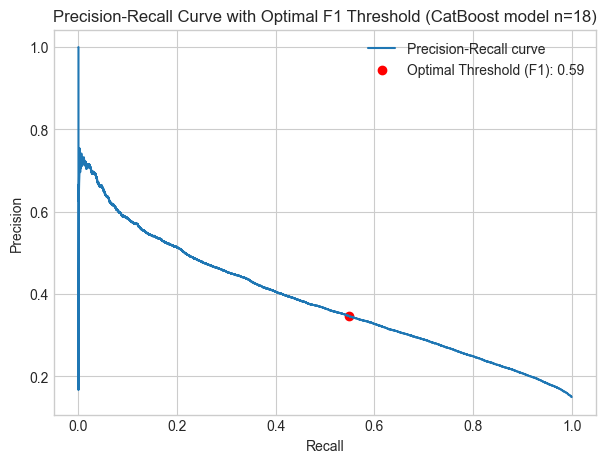

In [ ]:
precision, recall, pr_thresholds = precision_recall_curve(
    y_train_subsampled, positive_class_proba
)
closest_index = np.argmin(np.abs(pr_thresholds - best_threshold_f1))

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.scatter(
    recall[closest_index],
    precision[closest_index],   # +1 to align with precision array length
    marker="o",
    color="red",
    label=f"Optimal Threshold (F1): {best_threshold_f1:.2f}",
)
plt.title("Precision-Recall Curve with Optimal F1 Threshold (CatBoost model n=18)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

In [88]:
y_pred_optimized = (y_pred_proba[:, 1] >= best_threshold_f1).astype(int)
print(classification_report(y_train_subsampled, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86    141341
           1       0.35      0.55      0.42     24824

    accuracy                           0.78    166165
   macro avg       0.63      0.68      0.64    166165
weighted avg       0.83      0.78      0.80    166165



In [91]:
get_confusion_matrix_df(y_train_subsampled, y_pred_optimized)

,Predicted Negative (0),Predicted Positive (1)
Actual Negative (0),115670,25671
Actual Positive (1),11213,13611


#### 6.5.2. <a id='toc6_5_2_'></a>[CatBoost model n=36](#toc0_)

In [92]:
positive_cases = X_train_n36[y_train == 1]
negative_cases = X_train_n36[y_train == 0]

subsample_fraction = 0.5
negative_cases_subsampled = negative_cases.sample(
    frac=subsample_fraction, random_state=42
)

X_train_subsampled = pd.concat([positive_cases, negative_cases_subsampled])
y_train_subsampled = pd.concat(
    [
        y_train[y_train == 1],
        y_train[y_train == 0].sample(frac=subsample_fraction, random_state=42),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_proba = cross_val_predict(
    CatBoostClassifier(**params_n36, cat_features=cat_features_n36),
    X_train_subsampled,
    y_train_subsampled,
    cv=cv,
    method="predict_proba",
)

positive_class_proba = y_pred_proba[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [
    f1_score(y_train_subsampled, positive_class_proba >= t) for t in thresholds
]

best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f"Optimal threshold based on F1-score: {best_threshold_f1:.4f}")
print(f"Best F1-score at this threshold: {best_f1_score:.4f}")

Optimal threshold based on F1-score: 0.5700
Best F1-score at this threshold: 0.4082


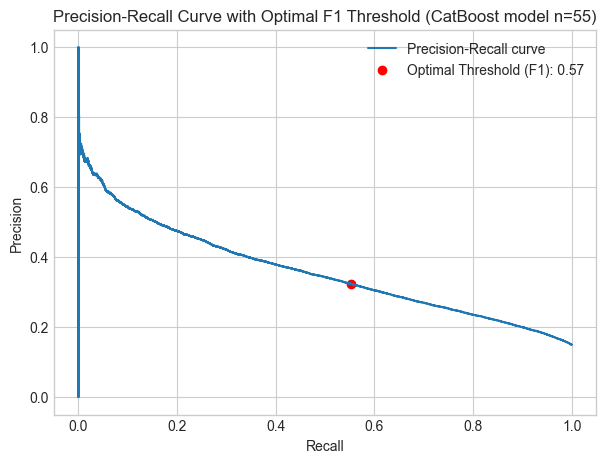

In [93]:
precision, recall, pr_thresholds = precision_recall_curve(
    y_train_subsampled, positive_class_proba
)
closest_index = np.argmin(np.abs(pr_thresholds - best_threshold_f1))

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.scatter(
    recall[closest_index],
    precision[closest_index],
    marker="o",
    color="red",
    label=f"Optimal Threshold (F1): {best_threshold_f1:.2f}",
)
plt.title("Precision-Recall Curve with Optimal F1 Threshold (CatBoost model n=55)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

In [94]:
y_pred_optimized = (y_pred_proba[:, 1] >= best_threshold_f1).astype(int)
print(classification_report(y_train_subsampled, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85    141341
           1       0.32      0.55      0.41     24824

    accuracy                           0.76    166165
   macro avg       0.62      0.67      0.63    166165
weighted avg       0.82      0.76      0.78    166165



In [95]:
get_confusion_matrix_df(y_train_subsampled, y_pred_optimized)

,Predicted Negative (0),Predicted Positive (1)
Actual Negative (0),112624,28717
Actual Positive (1),11095,13729


### 6.6. <a id='toc6_6_'></a>[Saving final pipelines and SHAP explainer ](#toc0_)

Handling CatBoost within sklearn pipeline can be a bit tricky. The core issue is that the `ColumnTransformer`'s output loses the categorical information that CatBoost needs. To fix this, we need a smarter way to handle the categorical features within the pipeline without breaking CatBoost's ability to recognize them. The most reliable way to do this is to pass the column indices of the categorical features directly to the CatBoost classifier within the pipeline.

In [112]:
numerical_features_n18 = X_train_n18.select_dtypes(include=np.number).columns
categorical_features_n18 = X_train_n18.select_dtypes(exclude=np.number).columns

preprocessor_n18 = ColumnTransformer(
    transformers=[
        (
            "num",
            SimpleImputer(strategy="constant", fill_value=0),
            numerical_features_n18,
        ),
        (
            "cat",
            SimpleImputer(strategy="constant", fill_value="missing"),
            categorical_features_n18,
        ),
    ],
    remainder="passthrough",
)

preprocessed_features = list(numerical_features_n18) + list(categorical_features_n18)
cat_features_indices = [
    preprocessed_features.index(col) for col in categorical_features_n18
]

pipeline_n18 = Pipeline(
    steps=[("preprocessor", preprocessor_n18), ("classifier", cat_model_n18_tuned)]
)

pipeline_n18.fit(X_train_n18, y_train, classifier__cat_features=cat_features_indices)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [113]:
joblib.dump(pipeline_n18, "../pipeline_n18.joblib")

['../pipeline_n18.joblib']

In [ ]:
explainer_n18 = shap.TreeExplainer(pipeline_n18.named_steps["classifier"])

joblib.dump(explainer_n18, "../shap_explainer_n18.joblib")

['shap_explainer_n18.joblib']

In [109]:
numerical_features_n36 = X_train_n36.select_dtypes(include=np.number).columns
categorical_features_n36 = X_train_n36.select_dtypes(exclude=np.number).columns

preprocessor_n36 = ColumnTransformer(
    transformers=[
        (
            "num",
            SimpleImputer(strategy="constant", fill_value=0),
            numerical_features_n36,
        ),
        (
            "cat",
            SimpleImputer(strategy="constant", fill_value="missing"),
            categorical_features_n36,
        ),
    ],
    remainder="passthrough",
)

preprocessed_features = list(numerical_features_n36) + list(categorical_features_n36)
cat_features_indices = [
    preprocessed_features.index(col) for col in categorical_features_n36
]

pipeline_n36 = Pipeline(
    steps=[("preprocessor", preprocessor_n36), ("classifier", cat_model_n36_tuned)]
)

pipeline_n36.fit(X_train_n36, y_train, classifier__cat_features=cat_features_indices)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [110]:
joblib.dump(pipeline_n36, "../pipeline_n36.joblib")

['../pipeline_n36.joblib']

In [ ]:
explainer_n36 = shap.TreeExplainer(pipeline_n36.named_steps["classifier"])

joblib.dump(explainer_n36, "../shap_explainer_n36.joblib")

['shap_explainer_n36.joblib']

## 7. <a id='toc7_'></a>[Test prediction and Submission](#toc0_)

Predicting the test data target and submitting the result on kaggle competition:

In [52]:
def predict_and_submit(model, test_data, model_name):
    """
    Submits the model predictions to Kaggle competition.
    """
    y_proba = model.predict_proba(test_data)[:, 1]

    submission = pd.DataFrame(
        {"SK_ID_CURR": app_test_merged["SK_ID_CURR"], "TARGET": y_proba}
    )

    submission.to_csv("../data/processed/submission.csv", index=False)

    api = KaggleApi()
    api.authenticate()

    api.competition_submit(
        file_name="../data/processed/submission.csv",
        message=model_name,
        competition="home-credit-default-risk",
    )

In [167]:
predict_and_submit(automl_1, X_test, "AutoML 1: Ensemble")

100%|██████████| 1.27M/1.27M [00:01<00:00, 1.03MB/s]


In [71]:
predict_and_submit(catboost_model_n18, test_pool_n18, "CatBoost: n=18 features")

100%|██████████| 1.27M/1.27M [00:01<00:00, 1.07MB/s]


In [73]:
predict_and_submit(
    catboost_model_n36, test_pool_n36, "CatBoost: n=36 features excl. EXT_SOURCE"
)

100%|██████████| 1.27M/1.27M [00:01<00:00, 1.06MB/s]


In [81]:
predict_and_submit(
    cat_model_n18_tuned,
    test_pool_n18,
    "CatBoost: n=18 features / tuned hyperparameters",
)

100%|██████████| 1.27M/1.27M [00:01<00:00, 1.06MB/s]


In [84]:
predict_and_submit(
    cat_model_n36_tuned,
    test_pool_n36,
    "CatBoost: n=36 features excl. EXT_SOURCE / tuned hyperparameters",
)

100%|██████████| 1.27M/1.27M [00:01<00:00, 1.08MB/s]


Review the public scores of the latest model submitted and compare it to the 5 models with the best scores:

In [2]:
api = KaggleApi()
api.authenticate()

submissions = api.competition_submissions("home-credit-default-risk")

valid_subs = [s for s in submissions if s.public_score is not None]

latest_submission = sorted(valid_subs, key=lambda x: x.date, reverse=True)[0]

top_subs = sorted(valid_subs, key=lambda x: x.public_score, reverse=True)

top_subs_filtered = [s for s in top_subs if s.ref != latest_submission.ref]

print("📌 Latest Submission:")
print(
    f"""
Date:         {latest_submission.date}
Description:  {latest_submission.description}
Public Score: {latest_submission.public_score}
Private Score: {latest_submission.private_score}
"""
)

print("🏆 All Submissions by ROC:")
for sub in top_subs_filtered:
    print(
        f"""
Date:         {sub.date}
Description:  {sub.description}
Public Score: {sub.public_score}
Private Score: {sub.private_score}
"""
    )

📌 Latest Submission:

Date:         2025-08-26 20:28:24.820000
Description:  CatBoost: n=36 features excl. EXT_SOURCE / tuned hyperparameters
Public Score: 0.75424
Private Score: 0.75889

🏆 All Submissions by ROC:

Date:         2025-08-05 15:47:25.223000
Description:  AutoML 8: Ensemble
Public Score: 0.78108
Private Score: 0.78347


Date:         2025-08-24 09:35:21.270000
Description:  AutoML 1: Ensemble
Public Score: 0.78080
Private Score: 0.78043


Date:         2025-08-05 22:28:39.850000
Description:  AutoML 9: Ensemble
Public Score: 0.77845
Private Score: 0.78073


Date:         2025-08-10 19:37:31.923000
Description:  CatBoost: Tuned & w/ optimized number of features
Public Score: 0.77683
Private Score: 0.77514


Date:         2025-08-24 10:29:52.280000
Description:  CatBoost: n=37 features / tuned hyperparameters
Public Score: 0.77240
Private Score: 0.77165


Date:         2025-08-24 11:45:35.670000
Description:  CatBoost: n=37 features / tuned hyperparameters
Public Score: 0.7

**Test Prediction Summary**

The AutoML ensembles demonstrated the strongest performance among all models tested, as evidenced by their public and private scores from the competition submissions. While ROC AUC scores were not the sole objective of this project, they served as a valuable metric for guiding predictive performance.

Multiple rounds of feature engineering and selection resulted in a wide range of models, varying from 18 to over (a few) 100 features, with ROC AUC scores ranging from 0.69 to 0.78. Notably, a model with 37 features achieved a private score of up to 0.77514.

The **final models**, featuring 18 and 36 features (excluding external data sources), represent a strong compromise between a limited number of features and high performance. These models, after final tuning, achieved the following private scores:



* n=18 features: 0.75316
* n=36 features: 0.75889